In [107]:
import os
import numpy as np
import keras
import tensorflow as tf
import tweepy
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
import string
import seaborn as sns
import nltk
import csv
import sklearn
import datetime
import tweepy
import textblob
import json
from wordcloud import WordCloud
from collections import Counter
from datetime import datetime
from textblob import TextBlob
from nltk.corpus import stopwords
from __future__ import print_function
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout, Activation, Flatten
from keras.utils import plot_model
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#nltk.download('stopwords')

%matplotlib inline
#os.getcwd()

### Section 1 Tweet Cleanup  ###

In [31]:
consumer_key='ggd6CdEGcktohgYVJbgkplCeM'
consumer_secret='T8lXrGE6Rz0xMnDWzR7IxL4D5WL3TSjgn2SV86vNKe49xhmEDG'
access_token='972996143474008065-Co06QR4JIP4SZH8EYuJ8LkW6PCNPslJ'
access_token_secret='huwRAC8BHAxK9i28CbVQEcuGsDw3X7jwRd5eDT1Ep61C0'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

name = "elonmusk"

my_list_of_dicts = []    
with open('tweetresults.txt', 'w') as file:
    tweets = tweepy.Cursor(api.user_timeline, screen_name = name).items(5000)
    for each_json_tweet in tweets:
        my_list_of_dicts.append(each_json_tweet._json)
    file.write(json.dumps(my_list_of_dicts, indent = 4)) 
    

In [32]:
my_demo_list = []
with open('tweetresults.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        text = each_dictionary['text']
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        created_at = each_dictionary['created_at']
        my_demo_list.append({'Text': str(text),
                             'Likes': int(favorite_count),
                             'Retweet': int(retweet_count),
                             'Date': created_at,
                             'Length': len(text)
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = 
                                  ['Text', 
                                   'Likes', 'Retweet', 
                                   'Date',
                                  'Length'])

In [34]:
(tweet_json.head(5))

,Text,Likes,Retweet,Date,Length
0,@krobertson @Tesla @kimbal @senorsisig Will do...,839,53,Sat Sep 29 15:43:29 +0000 2018,119
1,@alitofts @telsa @6pm Tesla will deliver your ...,1122,73,Sat Sep 29 02:01:15 +0000 2018,101
2,That was intense https://t.co/8308Zfmnoj,39529,3597,Sat Sep 29 00:12:12 +0000 2018,40
3,@Model3Owners i❤️🇨🇦,2283,187,Fri Sep 28 21:52:44 +0000 2018,19
4,@Model3Owners !! Will take action.,1856,62,Fri Sep 28 21:37:34 +0000 2018,34


In [35]:
# Data Cleanse #
tweet_json['Text'] = tweet_json['Text'].str.replace(r'http\S+', " ", case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace('RT @[\w]*', " ", case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace('&gt', " ", case=False)
tweet_json['Text'] = tweet_json['Text'].str.replace("[^a-zA-Z#]", " ", case=False)

In [36]:
# Test - Remove words < 3 characters (to remove stop words)#
tweet_json2 = tweet_json.copy()
tweet_json2['CText'] = tweet_json2['Text'].apply(lambda x: ' '.join([w for w in x.split() if
                                                           len(w)>3]))

In [37]:
#Tokenizer#
tokens = tweet_json2['CText'].apply(lambda x: x.split())
tokens.head()

0    [krobertson, Tesla, kimbal, senorsisig, Will, ...
1    [alitofts, telsa, Tesla, will, deliver, your, ...
2                                      [That, intense]
3                                      [Model, Owners]
4                  [Model, Owners, Will, take, action]
Name: CText, dtype: object

In [38]:
#Remove common words + stop words - NLTK #
# play, player, played, plays --> play #
stop_words = set(stopwords.words('english'))
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokens = tokens.apply(lambda x: [stemmer.stem(i)
                                         for i in x])

for i in range(len(tokens)):
    tokens[i] = ' '.join(tokens[i])

tokens2 = []
for w in tokens:
    if w not in stop_words:
        tokens2.append(w)
        
tweet_json2['Tokens'] = tokens
tweet_json2['Text'].replace('', np.nan, inplace=True)
tweet_json2.dropna(subset=['Text'], inplace=True)
tweet_json2['Date'] = pd.to_datetime(tweet_json2['Date']).dt.date
tweet_json2.head()

,Text,Likes,Retweet,Date,Length,CText,Tokens
0,krobertson Tesla kimbal senorsisig Will do...,839,53,2018-09-29,119,krobertson Tesla kimbal senorsisig Will Defini...,krobertson tesla kimbal senorsisig will defini...
1,alitofts telsa pm Tesla will deliver your ...,1122,73,2018-09-29,101,alitofts telsa Tesla will deliver your This fu...,alitoft telsa tesla will deliv your thi futur ...
2,That was intense,39529,3597,2018-09-29,40,That intense,that intens
3,Model Owners i,2283,187,2018-09-28,19,Model Owners,model owner
4,Model Owners Will take action,1856,62,2018-09-28,34,Model Owners Will take action,model owner will take action


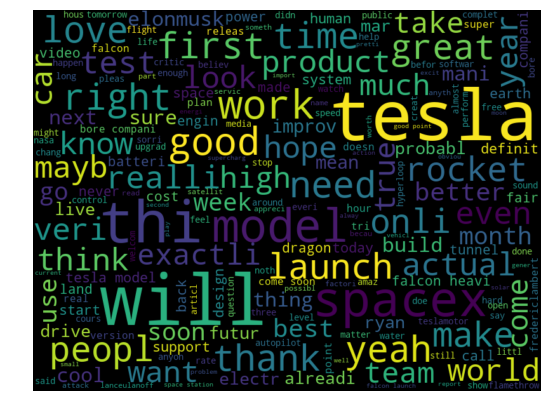

In [39]:
all_words = ' '.join([text for text in tweet_json2['Tokens']])
wordcloud = WordCloud(width=800, 
                      height=600, 
                      random_state=21, 
                      max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [40]:
## Text Blob - Sentiment Analysis (polarity) ##
def sentiment(x):
    sentValue = TextBlob(x)
    return sentValue.sentiment.polarity

tweet_json2['sentiment'] = tweet_json2['Text'].apply(sentiment)

conditions = [
    (tweet_json2['sentiment'] > 0 ),
    (tweet_json2['sentiment'] < 0),
    (tweet_json2['sentiment'] == 0)]

choices = ['positive', 'negative', 'neutral']
tweet_json2['Pol_Name'] = np.select(conditions, choices, default=' ')
#tweet_json2

In [41]:
#Total Stats#
print('total tweets', len(tweet_json2))
print('positive tweets', sum(tweet_json2['Pol_Name'] == 'positive')/len(tweet_json2)*100, '%')
print('negative tweets', sum(tweet_json2['Pol_Name'] == 'negative')/len(tweet_json2)*100, '%')
print('neutral tweets',sum(tweet_json2['Pol_Name'] == 'neutral')/len(tweet_json2)*100, '%')

total tweets 3224
positive tweets 43.579404466501245 %
negative tweets 15.10545905707196 %
neutral tweets 41.3151364764268 %


### Section 2 - LSTM Stock Analysis ###

In [90]:
tesla = pd.read_csv('TSLA.csv')
tesla.Date = pd.to_datetime(tesla.Date)
Prices = tesla[['Date', 'Close']].copy()
#Prices

In [76]:
# Average Sentiment - Multiple Tweets Per Day #
sent = tweet_json2[['Date', 'sentiment']].copy()
sent['Date'] = pd.to_datetime(sent['Date'], errors='coerce')
sent = sent.resample('D', on='Date')['sentiment'].sum()
sent = pd.DataFrame({'Date':sent.index, 'sentiment':sent.values})

In [93]:
print(len(sent))
print(len(Prices))
Prices.Date = pd.to_datetime(Prices.Date)
s1 = pd.merge(Prices, sent, how='left', on=['Date'])

692
477


In [113]:
# Train/Test #
train_size = int(len(s1) * .7)
test_size = len(s1) - train_size
train, test = s1[0:train_size], s1[train_size:len(s1)]

#print(len(train), len(test))